<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/DL03_from_video_NN_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAvgPool2D, Concatenate, Dense, Dropout, Flatten
# for images use Conv2D, we don't count the channels here, convolution is applied separately on each channel

from tensorflow.keras.applications import ResNet101

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 03. Neural Networks for Images
### from video

In [ ]:
(mnist_attributes_tarin, mnist_labels_train), (mnist_attributes_test, mnist_labels_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
(mnist_attributes_tarin.shape, mnist_labels_train.shape), (mnist_attributes_test.shape, mnist_labels_test.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

mnist has 1 channel, need to expand the dimentions to match expected from conv 2d, in tf default order is width, height, channels

In [ ]:
mnist_attributes_tarin = tf.expand_dims(mnist_attributes_tarin, -1).numpy() # -1 axis
mnist_attributes_test = tf.expand_dims(mnist_attributes_test, -1).numpy()
mnist_attributes_tarin.shape, mnist_attributes_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
INPUT_SHAPE = mnist_attributes_tarin.shape[1:]
INPUT_SHAPE

(28, 28, 1)

In [ ]:
NUM_CLASSES = len(set(mnist_labels_train))
NUM_CLASSES

10

Inferring input and output shapes is a bit dangerous, better hardcode them or put the configuration in a cofig file and save it in mlflow.

```strides``` is feature selection (choosing which pixels to include in calculations)

```max_pooling``` is dimensionality reduction (calculate all and then take max pixel value)

result dimensions are the same

```Dropout``` after Conv layer is a mistake! Instead of excluding whole filter from training (which would be helpful) it makes some elements in a filter = 0 and distorts the filter. This mistake is very hard to find, because everything seems to be working. Use ```SpatialDropout2D``` instead.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential([
    Input(INPUT_SHAPE),
    Conv2D(32, 3, strides = 2, padding = "same", activation = "relu"),
    Conv2D(32, 3, padding = "same", activation = "relu"),
    MaxPool2D(), # no need for activation
    Conv2D(16, 3, padding = "same", activation = "relu"),
    Conv2D(16, 3, padding = "same", activation = "relu"),

    # Conv2D(10, 1, activation = "relu"), equivalent to classificaton, for GPU is good option

    # Flatten(),
    GlobalAvgPool2D(),

    Dense(16, activation = "relu"),
    Dropout(0.05),

    Dense(NUM_CLASSES, activation = "softmax")

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 32)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          2320      
                                                                 
 global_average_pooling2d (  (None, 16)                0         
 GlobalAveragePooling2D)                                

Default optimizer doesn't work well with convolutional NNs. Because of the many layers in both depth and width, we need optimizer with very, very small learning rate. Adam has 3 hyperparameters ($\beta_1, \beta_2, ϵ$), for convolutions $ϵ$ needs to be smaller tahn default.

In [ ]:
model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

```validation_split``` takes persentage from training data for validation - downside - for every epoch these are different data

In [ ]:
model.fit(mnist_attributes_tarin, mnist_labels_train, epochs = 5, validation_split = 0.1)

Epoch 1/5
1688/1688 [==============================] - 57s 33ms/step - loss: 0.5172 - accuracy: 0.8298 - val_loss: 0.1161 - val_accuracy: 0.9650
Epoch 2/5
1688/1688 [==============================] - 56s 33ms/step - loss: 0.1511 - accuracy: 0.9526 - val_loss: 0.0730 - val_accuracy: 0.9792
Epoch 3/5
1688/1688 [==============================] - 57s 34ms/step - loss: 0.1094 - accuracy: 0.9663 - val_loss: 0.0569 - val_accuracy: 0.9828
Epoch 4/5
1688/1688 [==============================] - 61s 36ms/step - loss: 0.0908 - accuracy: 0.9721 - val_loss: 0.0673 - val_accuracy: 0.9812
Epoch 5/5
1688/1688 [==============================] - 58s 34ms/step - loss: 0.0764 - accuracy: 0.9767 - val_loss: 0.0541 - val_accuracy: 0.9827


In [ ]:
model.evaluate(mnist_attributes_test, mnist_labels_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0532 - accuracy: 0.9815


[0.053196631371974945, 0.9815000295639038]

In [ ]:
model.save_weights("sample_conv_model_global_pooling.h5")

### Convolutional NN

feature map = results after each layer

Conv layers and NNs don't care about the size of the input image, everything will work as long as there is no dense layer somewhere

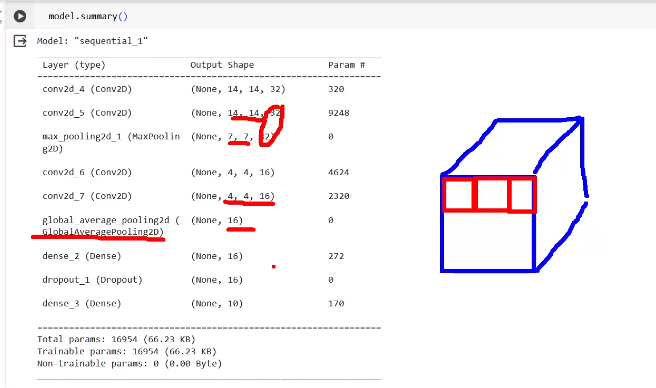

```max_pooling``` or ```avg_pooling``` reduce width and height (take one value from a pool of pixels) and keep the number of channels

```global_max_pooling``` is the opposite - keeps 1 element for each channel, global means applied on the whole image at once

```global_pooling``` reduces the output dimensions way more than ```flatten``` - here 16 (4x4) times; for small conv volumes flatten is ok, global pooling is generally preffered

We can use batch normalisation and all the other tricks in the book for a conv NN.

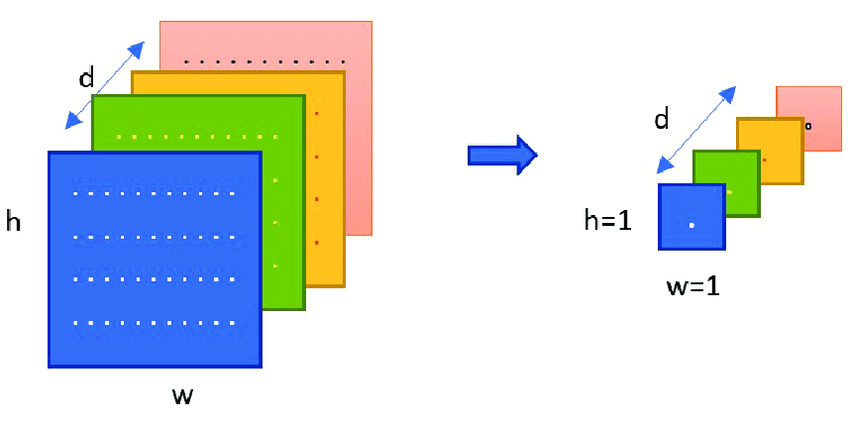

In [ ]:
len(model.layers[0].weights) # list with kernel, bias

2

In [ ]:
model.layers[0].kernel.shape # width x height x channels, num_filters

TensorShape([3, 3, 1, 32])

In [ ]:
model.layers[0].kernel[:, :, :, 0].shape

TensorShape([3, 3, 1])

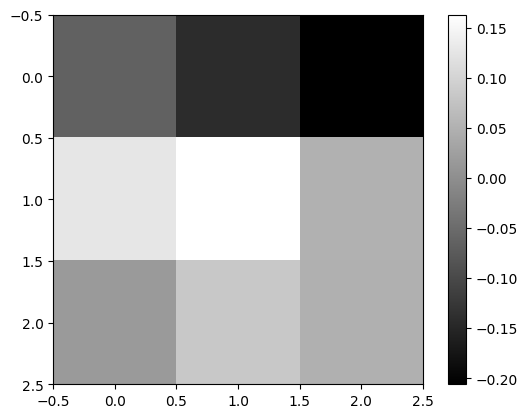

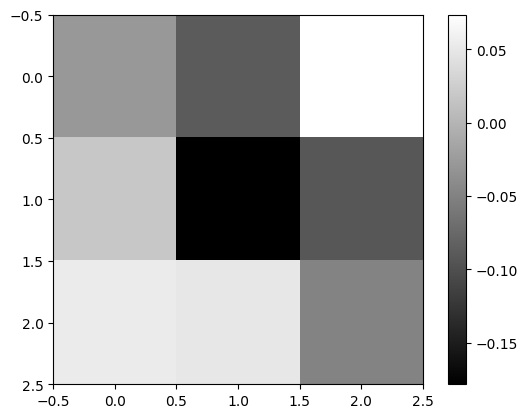

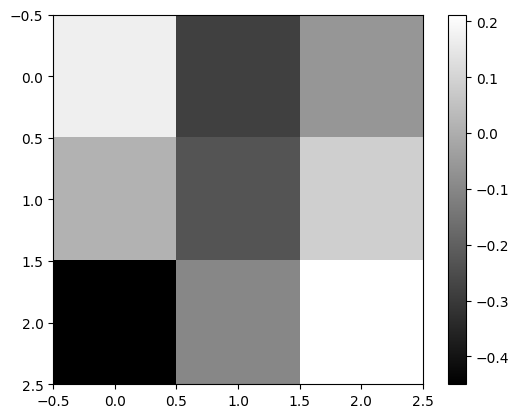

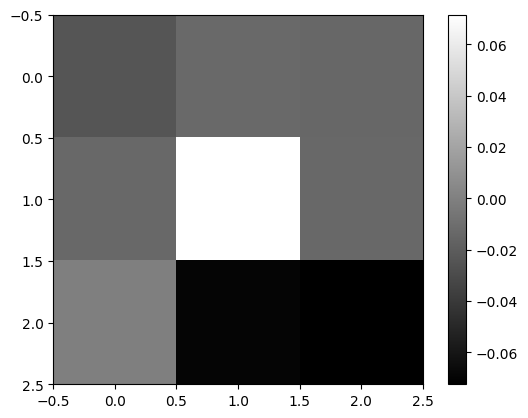

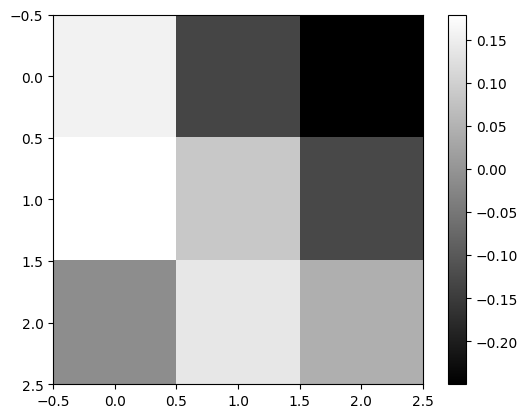

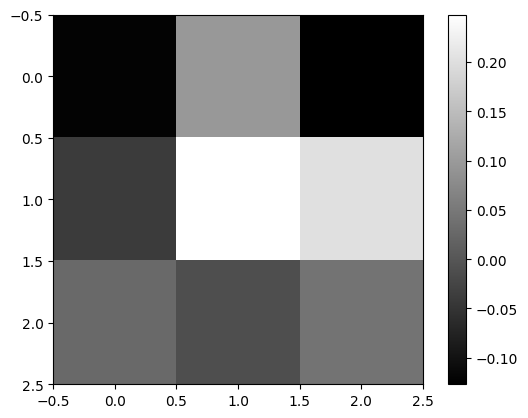

In [ ]:
for i in range(6):
  plt.imshow(model.layers[0].kernel[:, :, :, i], cmap = "gray") # beware of matplotlib's hidden normalisation
  plt.colorbar()
  plt.show()

In [ ]:
model.layers[3].kernel.shape

TensorShape([3, 3, 32, 16])

We can visualise the filters of the first conv layer - interpretability.

That does not apply for inner conv layers - something with 32 channels cannot be interpreted as image.

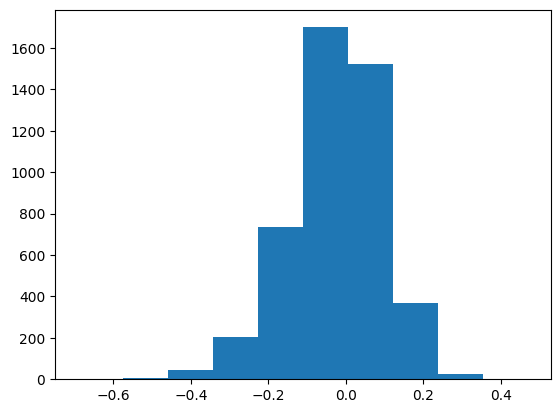

In [ ]:
plt.hist(model.layers[3].kernel.numpy().ravel())
plt.show()

## Reccurent NN

In [ ]:
input = Input((20, 20, 32))

In [ ]:
x = Conv2D(32, (3,3), padding = "same", activation = "relu")(input)
resnet_block_start = Conv2D(32, (3,3), padding = "same", activation = "relu")(x) # or overwrite previous x

long_path = Conv2D(32, (3,3), padding = "same", activation = "relu")(resnet_block_start)
long_path = Conv2D(32, (3,3), padding = "same", activation = "relu")(long_path)

concat = Concatenate()([long_path, resnet_block_start]) # old implementation is Add() - elementwise addition

x = Conv2D(32, (3,3), activation = "relu")(concat)


In [ ]:
x

<KerasTensor: shape=(None, 18, 18, 32) dtype=float32 (created by layer 'conv2d_53')>

In [ ]:
resnet_block = Model(inputs = [resnet_block_start], outputs = [concat])

In [ ]:
resnet_block.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 20, 32)]         0         []                            
                                                                                                  
 conv2d_51 (Conv2D)          (None, 20, 20, 32)           9248      ['input_3[0][0]']             
                                                                                                  
 conv2d_52 (Conv2D)          (None, 20, 20, 32)           9248      ['conv2d_51[1][0]']           
                                                                                                  
 concatenate_7 (Concatenate  (None, 20, 20, 64)           0         ['conv2d_52[1][0]',           
 )                                                                   'input_3[0][0]']       

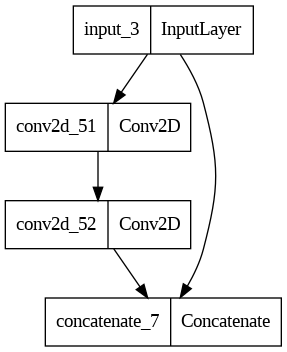

In [ ]:
tf.keras.utils.plot_model(resnet_block)

In [ ]:
Concatenate()([concat, concat])

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'concatenate_8')>

In [ ]:
x = Conv2D(32, (1, 1))(input) # Dense(1) here loses the filters and changes the shape, instead we use 1x1 conv => network in network
# a way to enbed fully connected NN inside convolutional NN

In [ ]:
one_by_one_conv = Model(inputs = [input], outputs = [x])

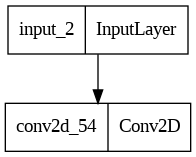

In [ ]:
tf.keras.utils.plot_model(one_by_one_conv)

In [ ]:
one_by_one_conv.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 20, 32)]      0         
                                                                 
 conv2d_54 (Conv2D)          (None, 20, 20, 32)        1056      
                                                                 
Total params: 1056 (4.12 KB)
Trainable params: 1056 (4.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Network in Network

Google's Inception - if you don't know which are the important features - trow them all in and let the model choose

No way to make classic hyperparameter search --> model distillation

In [ ]:
resnet = ResNet101(weights = "imagenet", include_top = False)

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
# resnet.summary()

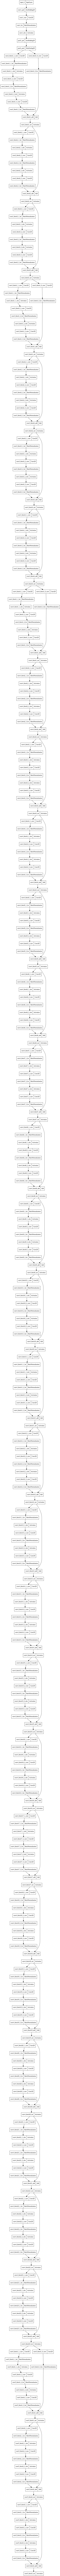

In [ ]:
tf.keras.utils.plot_model(resnet)

In [ ]:
Model( outputs = resnet.output)

TypeError: ignored

In [ ]:
Model(inputs = resnet.input, outputs = x)

In [ ]:
x = Dense(NUM_CLASSES, activation = "softmax")(resnet.output)

In [ ]:
x

<KerasTensor: shape=(None, None, None, 10) dtype=float32 (created by layer 'dense_3')>

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

__transfer learning__ - frozen model + new head

__finetuning__ - continiue training the whole already trained model (meaning same task)

and a whole world of posibilities in between - unfreeze from the end - more data or more different task - more unfrozen layers

one unskippable condition - same INPUT SHAPE - even if we make it match, tere is no guarantee the model will behave propperly on the new kind of input

+ Tensorflow hub
+ Tensorflow vision


In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.9/601.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
import keras_cv

Using TensorFlow backend


In [ ]:
keras_cv.models.ResNet101V2Backbone

keras_cv.src.models.backbones.resnet_v2.resnet_v2_aliases.ResNet101V2Backbone

In [ ]:
classifier = keras_cv.models.ImageClassifier(backbone = keras_cv.models.ResNet101V2Backbone(), num_classes = 2) # NUM_Classes

NameError: ignored

In [ ]:
 keras_cv.bounding_box.XYWH

+ preprocessing layers

## HW

#### 1. model interpretation

ready model + interpretation method (Grad-CAM - saliency map / zfnet - encoder-decoder on specific layer)

#### 2. data feed


In [ ]:
image_settings = ImageDataGenerator() # resizes by default

In [ ]:
training_data = image_settings.flow_from_directory("/content/gdrive/MyDrive/dog_vs_muffin_test")

Found 346 images belonging to 2 classes.


In [ ]:
batch = next(training_data)

In [ ]:
batch[0].shape, batch[1].shape # images; one_hot_encoded classes

((32, 256, 256, 3), (32, 2))

In [ ]:
np.max(batch[0][10]), np.min(batch[0][10])

(255.0, 0.0)

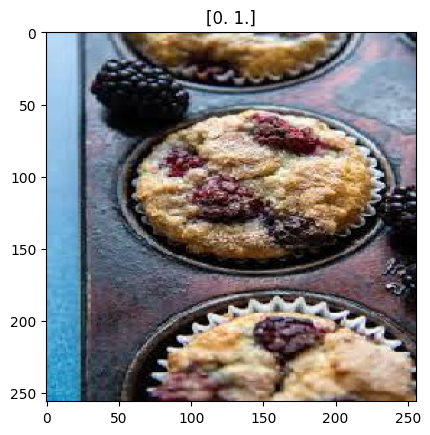

In [ ]:

plt.imshow(batch[0][10]/255, cmap = "gray")
plt.title(str(batch[1][10]))
plt.show()

Conv NNs are translation invariant (doesn't matter where the object in the image is, this is how sliding window works), but suck at rotated images

Small transformations of the initial images lead to catastrophic results - textbook overfit - remedy - oversampling, but with small additions - rotation, flip, noise, rescaling, contrast and aaaall the image preprocessing layers - augmentation

In [ ]:
classifier.compile(loss = "categorical_crossentropy")

NameError: ignored

In [ ]:
history = classifier.fit(training_data)

NameError: ignored